In [ ]:
#pip install bstpp

In [ ]:
import bstpp

In [ ]:
#pip install --upgrade scipy jax jaxlib

In [ ]:
from bstpp.main import LGCP_Model, Hawkes_Model

/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.6.1, so it will not be used.
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import numpyro.distributions as dist
from shapely.geometry import box

#**CONFIGURATION**

In [ ]:
EVENTS_PATH = "/kaggle/input/coviduk/london_covid_events.csv"
COVARIATES_PATH = "/kaggle/input/coviduk/london_covid_covariates.csv"
OUTPUT_DIR = "/kaggle/working/"
FIGURE_DIR = "/kaggle/working/"
SHAPEFILE_PATH = "/kaggle/input/coviduk/Greater_London_Authority_(GLA).shp"  # Update path if available


SUBSET_SIZE = 10000

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(FIGURE_DIR, exist_ok=True)

#**LOAD DATA**

In [ ]:
events_df = pd.read_csv(EVENTS_PATH)
events_df = events_df.sample(n=SUBSET_SIZE, random_state=42).sort_values("T").reset_index(drop=True)
#events_df = events_df[events_df["T"] <= 40].copy()

print("Subset events data:")
print(events_df.head())

Subset events data:
          X        Y    T
0  0.050093  51.4639  0.0
1 -0.189780  51.4964  0.0
2 -0.218190  51.6111  0.0
3 -0.036470  51.5155  0.0
4 -0.188680  51.4106  0.0


In [ ]:
events_df['T'].unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139.])

In [ ]:
len(events_df)

10000

#**EDA - EXPLORATORY DATA ANALYSIS**

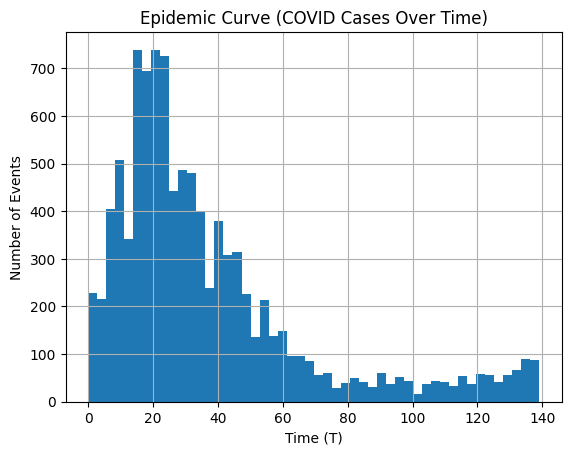

In [ ]:
# Epidemic curve
plt.figure()
events_df["T"].hist(bins=50)
plt.xlabel("Time (T)")
plt.ylabel("Number of Events")
plt.title("Epidemic Curve (COVID Cases Over Time)")
plt.savefig(f"{FIGURE_DIR}/eda_epidemic_curve.png")
plt.show()

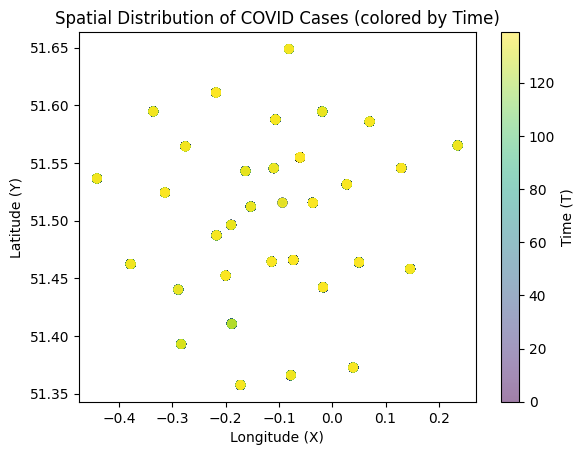

In [ ]:
# Spatial plot colored by time
plt.figure()
plt.scatter(events_df["X"], events_df["Y"], c=events_df["T"], cmap="viridis", alpha=0.5)
plt.xlabel("Longitude (X)")
plt.ylabel("Latitude (Y)")
plt.title("Spatial Distribution of COVID Cases (colored by Time)")
plt.colorbar(label="Time (T)")
plt.savefig(f"{FIGURE_DIR}/eda_spatial_scatter.png")
plt.show()

<Figure size 1200x1600 with 0 Axes>

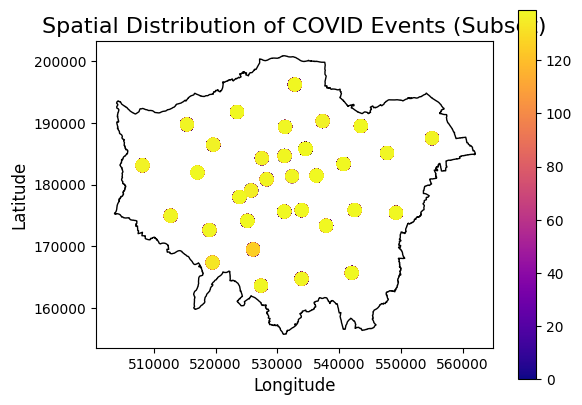

In [ ]:
if SHAPEFILE_PATH and os.path.exists(SHAPEFILE_PATH):
    # Load shapefile
    shp = gpd.read_file(SHAPEFILE_PATH)

    # Assign CRS if missing
    if shp.crs is None:
        shp = shp.set_crs("EPSG:27700")

    # Prepare events as GeoDataFrame
    events_gdf = gpd.GeoDataFrame(events_df, geometry=gpd.points_from_xy(events_df["X"], events_df["Y"]))
    events_gdf.crs = "EPSG:4326"
    events_gdf = events_gdf.to_crs(shp.crs)

    # Plot with larger figure and better points
    plt.figure(figsize=(12, 16))
    ax = shp.plot(color='white', edgecolor='black', linewidth=1)

    # Plot points, larger size and clearer colormap
    events_gdf.plot(ax=ax, column='T', cmap='plasma', markersize=80, alpha=0.8, legend=True)

    # Add titles and labels
    plt.title("Spatial Distribution of COVID Events (Subset)", fontsize=16)
    plt.xlabel("Longitude", fontsize=12)
    plt.ylabel("Latitude", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Save and show
    plt.savefig(f"{FIGURE_DIR}/eda_spatial_on_shapefile.png", bbox_inches='tight')
    plt.show()


#**DEFINE SPATIAL DOMAIN**

In [ ]:

x_min, x_max = events_df["X"].min() - 0.005, events_df["X"].max() + 0.005
y_min, y_max = events_df["Y"].min() - 0.005, events_df["Y"].max() + 0.005
grid_bounds = np.array([[x_min, x_max], [y_min, y_max]])

T_max = events_df["T"].max() + 7


In [ ]:
priors = {
    "a_0": dist.Normal(1, 10),
    "alpha": dist.Beta(20, 60),
    "beta": dist.HalfNormal(2.0),
    "sigmax_2": dist.HalfNormal(0.25),
}

INFO:2025-05-21 23:31:21,972:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [ ]:
MCMC_WARMUP = 100
MCMC_SAMPLES = 400
MCMC_CHAINS = 1

In [ ]:
SVI_STEPS = 15000
SVI_LR = 0.02
GRID_RESOLUTION = 0.5
SAMPLE_EVENTS = 10000

# LOAD + SAMPLE EVENTS

In [ ]:
#events_df_full = pd.read_csv(EVENTS_PATH)

# Sample events
#events_df = events_df_full.sample(n=min(SAMPLE_EVENTS, len(events_df_full)), random_state=42).reset_index(drop=True)

#T_max = events_df["T"].max() + 7
#grid_bounds = np.array([
    #[events_df["X"].min() - 0.005, events_df["X"].max() + 0.005],
   # [events_df["Y"].min() - 0.005, events_df["Y"].max() + 0.005],
#])

# Prepare events GeoDataFrame
events_gdf = gpd.GeoDataFrame(events_df, geometry=gpd.points_from_xy(events_df.X, events_df.Y))
events_gdf.crs = "EPSG:4326"

# LOAD + SAMPLE SPATIAL COVARIATES

In [ ]:
covariates_df_raw = pd.read_csv(COVARIATES_PATH).drop_duplicates(subset=["X", "Y"]).reset_index(drop=True)

covariates_gdf = gpd.GeoDataFrame(covariates_df_raw, geometry=gpd.points_from_xy(covariates_df_raw.X, covariates_df_raw.Y))
covariates_gdf.crs = "EPSG:4326"

covariates_gdf = covariates_gdf.to_crs("EPSG:27700")

# Create polygons
grid_size = 2000  # meters
polygons = []
for point in covariates_gdf.geometry:
    x, y = point.x, point.y
    polygons.append(box(x - grid_size/2, y - grid_size/2, x + grid_size/2, y + grid_size/2))

covariates_gdf['geometry'] = polygons
covariates_gdf.crs = "EPSG:27700"
covariates_gdf = covariates_gdf.to_crs("EPSG:4326")

spatial_cov = covariates_gdf

In [ ]:
events_gdf.head()

,X,Y,T,geometry
0,0.050093,51.4639,0.0,POINT (0.05009 51.46390)
1,-0.189780,51.4964,0.0,POINT (-0.18978 51.49640)
2,-0.218190,51.6111,0.0,POINT (-0.21819 51.61110)
3,-0.036470,51.5155,0.0,POINT (-0.03647 51.51550)
4,-0.188680,51.4106,0.0,POINT (-0.18868 51.41060)


In [ ]:
spatial_cov.head()

,X,Y,popdensity,covid_deaths,popn,houseprice,geometry
0,-0.093510,51.5156,3361,0,9721,855000,"POLYGON ((-0.07948 51.50638, -0.07873 51.52435..."
1,0.129479,51.5456,5898,0,212906,316000,"POLYGON ((0.14347 51.53635, 0.14431 51.55432, ..."
2,-0.218190,51.6111,4563,0,395869,530000,"POLYGON ((-0.20411 51.60189, -0.20340 51.61987..."
3,0.146212,51.4582,4099,1,248287,358000,"POLYGON ((0.16017 51.44895, 0.16102 51.46692, ..."
4,-0.275680,51.5644,7628,1,329771,485000,"POLYGON ((-0.26160 51.55520, -0.26092 51.57317..."


# LGCP MODEL

In [ ]:
spatial_cov.columns

Index(['X', 'Y', 'popdensity', 'covid_deaths', 'popn', 'houseprice',
       'geometry'],
      dtype='object')

In [ ]:
lgcp_cov_priors = {
    "a_0": dist.Normal(0, 10)
}

covariate_columns = ['popdensity', 'covid_deaths', 'popn', 'houseprice']

lgcp_cov = LGCP_Model(events_gdf, grid_bounds, T_max,
                  cov_grid_size=(GRID_RESOLUTION, GRID_RESOLUTION),
                  spatial_cov=spatial_cov,
                  cov_names=covariate_columns,
                  **priors)


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:2195: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026
/usr/local/lib/python3.11/dist-packages/bstpp/main.py:213: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersect['area'] = intersect.area/((A_[0,1]-A_[0,0])*(A_[1,1]-A_[1,0]))


Running LGCP SVI...


100%|██████████| 15000/15000 [00:18<00:00, 820.99it/s, init loss: -3947.7898, avg. loss [14251-15000]: -147610.2769] 


Sampling Posterior...

SVI elapsed time: 42.53524327278137


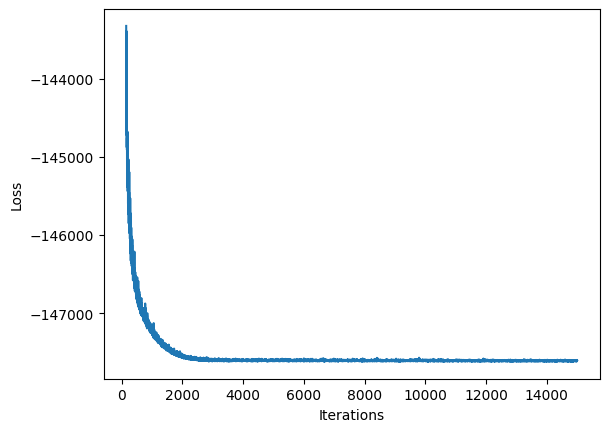

SVI Completed and saved.


In [ ]:
print("Running LGCP SVI...")

lgcp_cov.run_svi(num_steps=SVI_STEPS, lr=SVI_LR, plot_loss=True)
lgcp_cov.save_rslts(f"{OUTPUT_DIR}/lgcp_cov_svi.pkl")

print("SVI Completed and saved.")

In [ ]:
lgcp_cov.expected_AIC()

-147679.046875

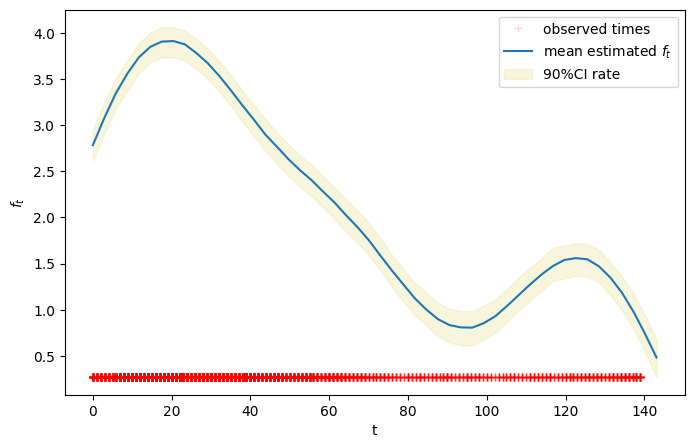

In [ ]:
lgcp_cov.plot_temporal()

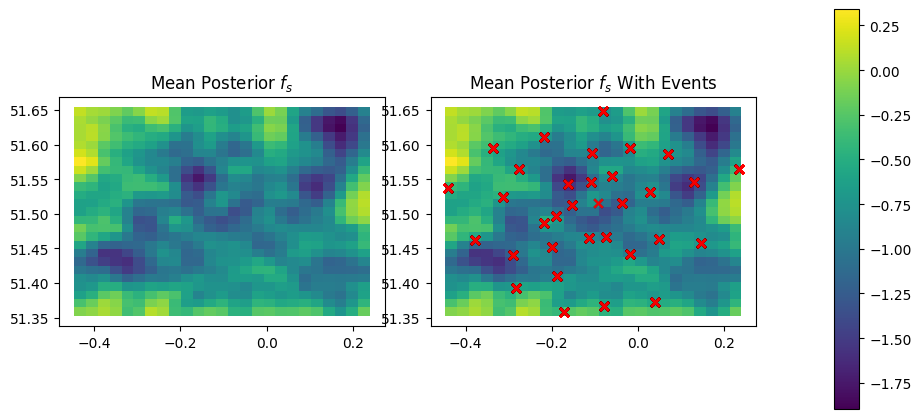

In [ ]:
lgcp_cov.plot_spatial()

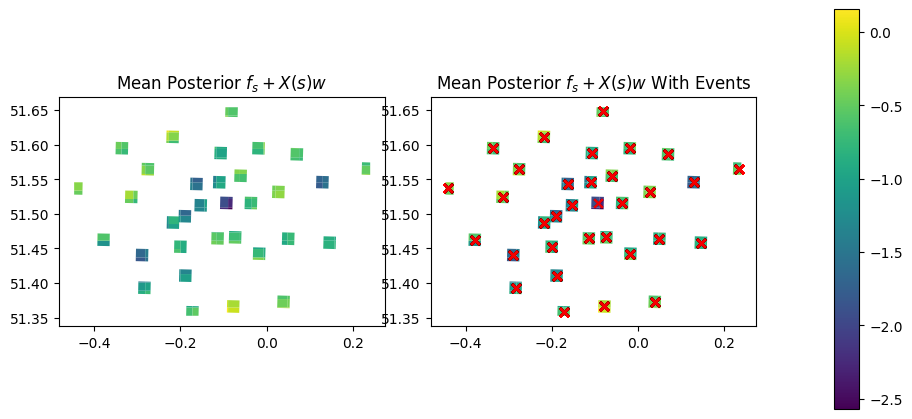

In [ ]:
lgcp_cov.plot_spatial(include_cov=True)

,Post Mean,Post Std,P(w>0),[0.025,0.975]
popdensity,0.110537,0.022970,1.000,0.067643,0.154407
covid_deaths,0.001997,0.011213,0.574,-0.019987,0.024139
popn,0.273877,0.013963,1.000,0.247653,0.302267
houseprice,-0.081664,0.020702,0.000,-0.121229,-0.040960
a_0,5.907145,0.109910,1.000,5.689286,6.116836


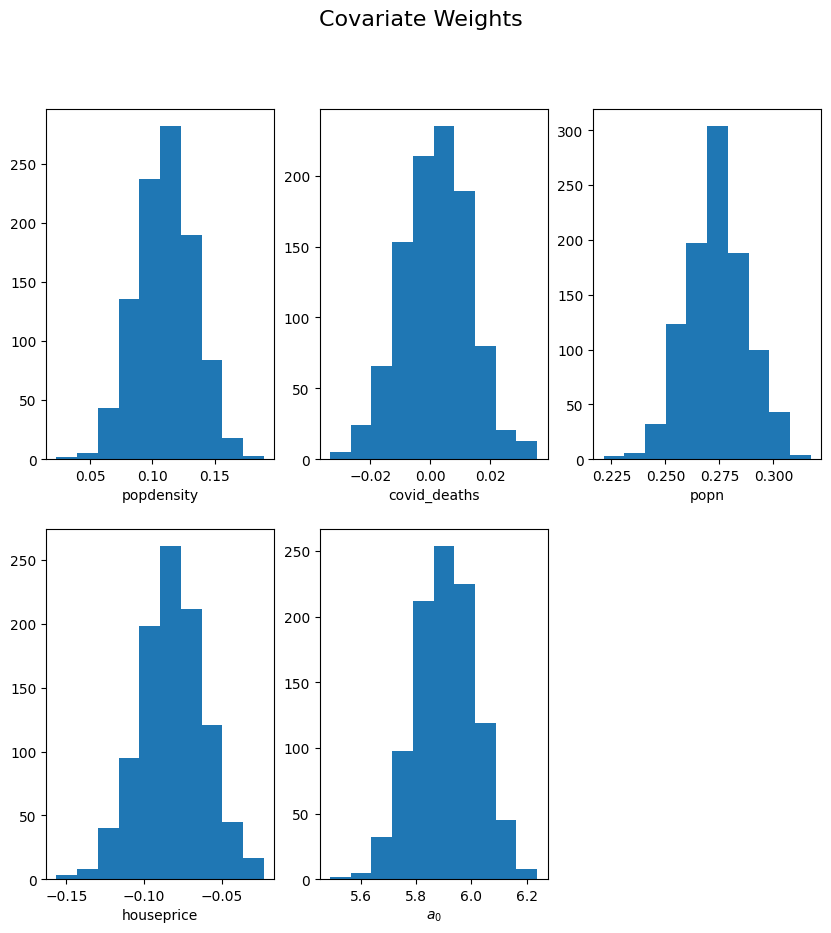

In [ ]:
lgcp_cov.cov_weight_post_summary()

In [ ]:
print("Running lgcp_cov MCMC...")

lgcp_cov.run_mcmc(num_warmup=MCMC_WARMUP, num_samples=MCMC_SAMPLES, num_chains=MCMC_CHAINS)
lgcp_cov.save_rslts(f"{OUTPUT_DIR}/lgcp_cov_mcmc.pkl")

print("MCMC Completed and saved.")

Running lgcp_cov MCMC...


sample: 100%|██████████| 500/500 [01:12<00:00,  6.92it/s, 319 steps of size 1.08e-02. acc. prob=0.94] 



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
           a_0      5.99      0.41      6.04      5.39      6.63     81.74      1.02
          w[0]      0.11      0.02      0.11      0.08      0.15    545.34      1.00
          w[1]      0.00      0.01      0.00     -0.02      0.02    513.70      1.00
          w[2]      0.27      0.01      0.27      0.25      0.30    542.37      1.00
          w[3]     -0.08      0.02     -0.08     -0.11     -0.04    611.97      1.00
  z_spatial[0]      0.59      0.02      0.59      0.56      0.63    426.80      1.02
  z_spatial[1]      0.31      0.04      0.31      0.25      0.36    375.06      1.03
  z_spatial[2]      0.19      0.01      0.19      0.16      0.21    344.50      1.00
  z_spatial[3]      0.16      0.01      0.16      0.13      0.18    538.25      1.00
  z_spatial[4]      0.01      0.02      0.01     -0.02      0.04    485.46      1.00
  z_spatial[5]      0.12      0.02      0.12      0.10      0.15

In [ ]:
lgcp_cov.expected_AIC()

-147684.125

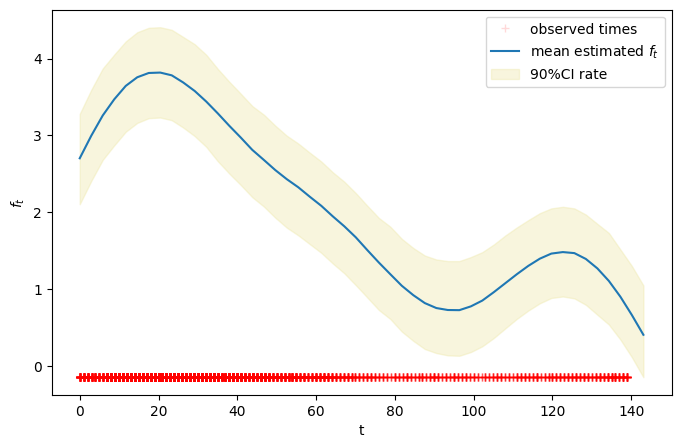

In [ ]:
lgcp_cov.plot_temporal()

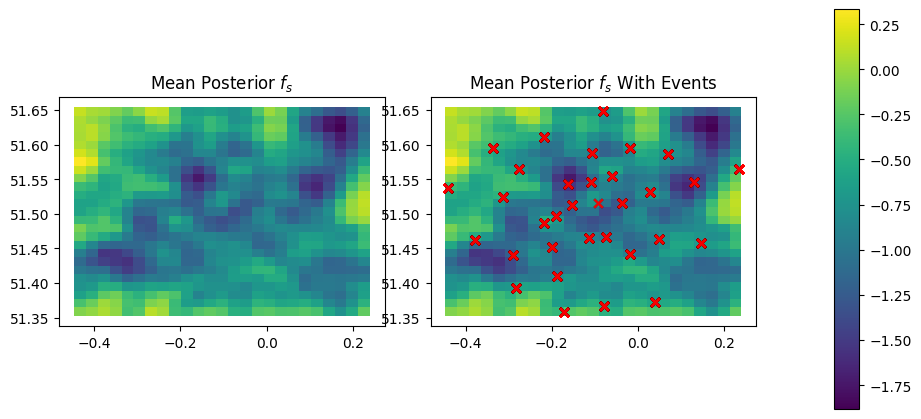

In [ ]:
lgcp_cov.plot_spatial()

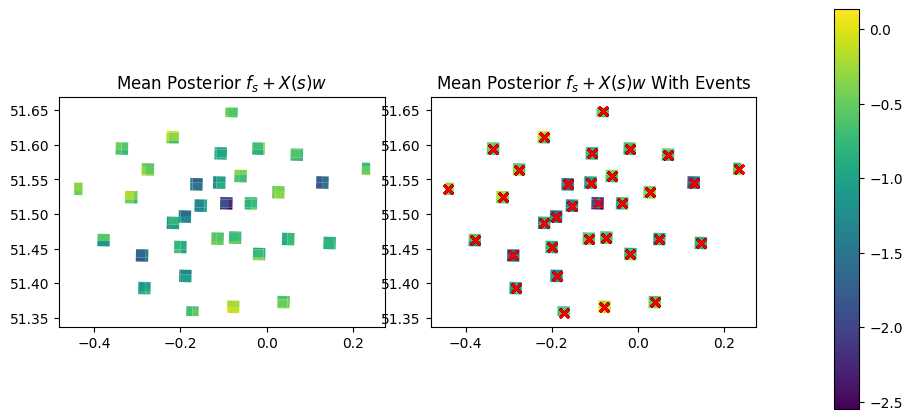

In [ ]:
lgcp_cov.plot_spatial(include_cov=True)

Plotting LGCP Intensity maps...


<Figure size 1000x600 with 0 Axes>

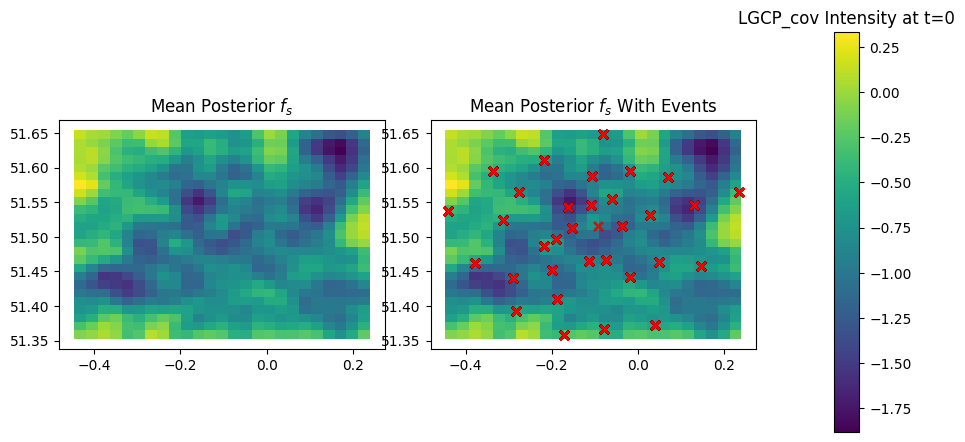

<Figure size 1000x600 with 0 Axes>

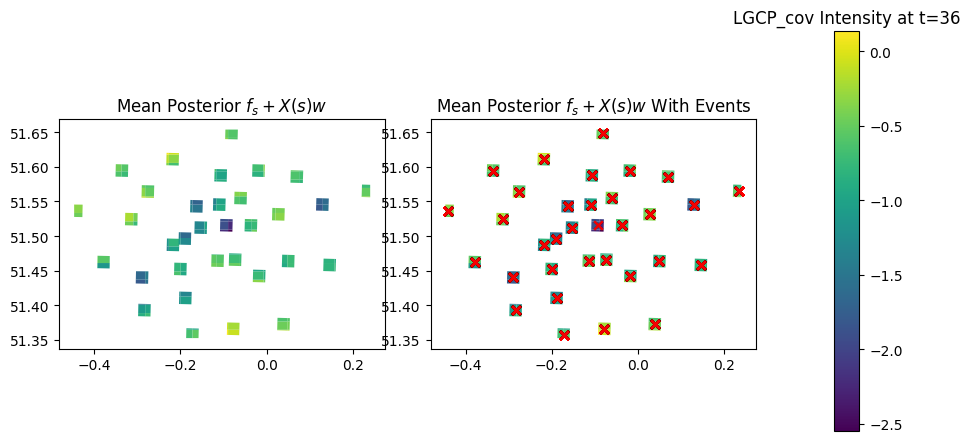

<Figure size 1000x600 with 0 Axes>

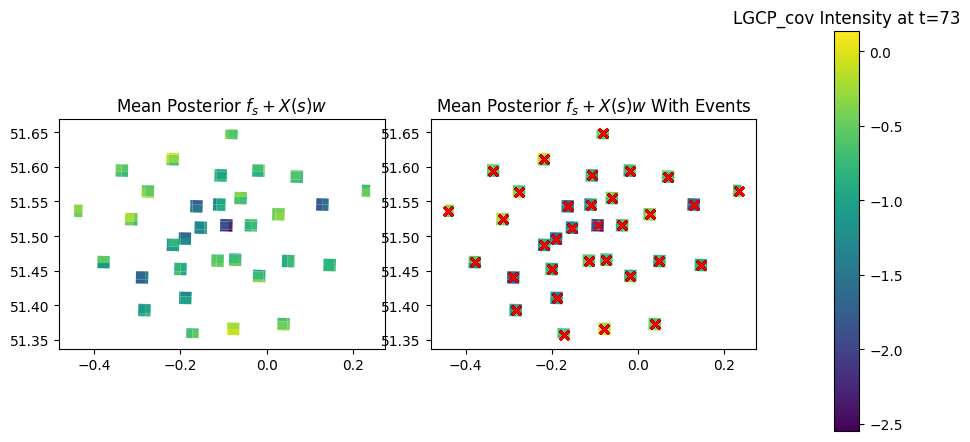

<Figure size 1000x600 with 0 Axes>

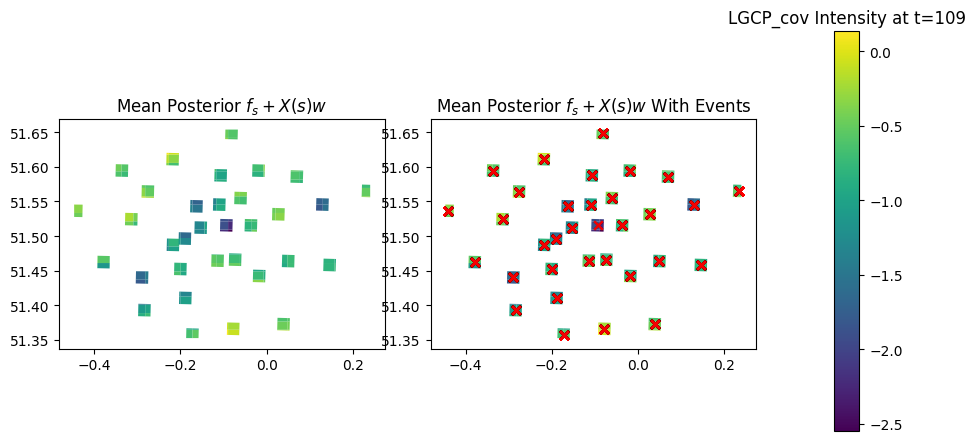

<Figure size 1000x600 with 0 Axes>

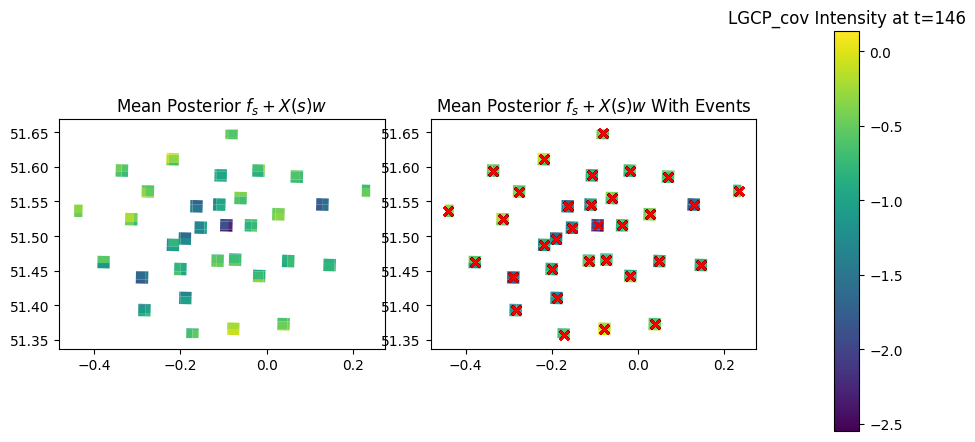

In [ ]:
print("Plotting LGCP Intensity maps...")

time_slices = np.linspace(0, T_max, 5)

for t in time_slices:
    plt.figure(figsize=(10, 6))
    lgcp_cov.plot_spatial(t)
    plt.title(f"LGCP_cov Intensity at t={int(t)}")
    plt.savefig(f"{FIGURE_DIR}/lgcp_cov_mcmc_intensity_t{int(t)}.png")
    plt.show()

,Post Mean,Post Std,P(w>0),[0.025,0.975]
popdensity,0.112875,0.022990,1.00,0.064419,0.157221
covid_deaths,0.002917,0.012493,0.58,-0.021390,0.027847
popn,0.270491,0.014901,1.00,0.240271,0.299377
houseprice,-0.078467,0.021105,0.00,-0.120090,-0.036503
a_0,5.994058,0.409064,1.00,5.108048,6.750474


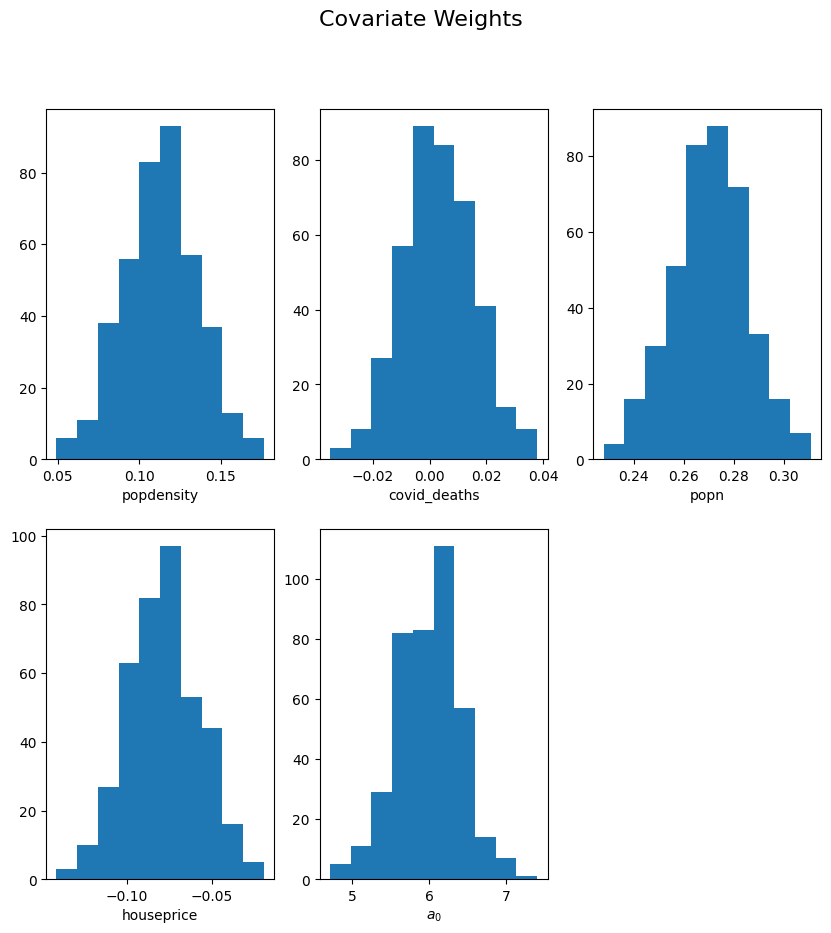

In [ ]:
lgcp_cov.cov_weight_post_summary()

# Cox-Hawkes


In [ ]:
# ---------------------------
# Define Priors for Cox-Hawkes
# ---------------------------

coxhawkes_cov_priors = {
     "a_0": dist.Normal(1, 10),
    "alpha": dist.Beta(20, 60),
    "beta": dist.HalfNormal(2.0),
    "sigmax_2": dist.HalfNormal(0.25)
}





In [ ]:
# ---------------------------
# Initialize Cox-Hawkes Model
# ---------------------------

coxhawkes_cov = Hawkes_Model(events_gdf, grid_bounds, T_max,
                         cox_background=True,
                         spatial_cov=spatial_cov,
                         cov_names=covariate_columns,
                         **coxhawkes_cov_priors)

print("Initialized Cox-Hawkes model.")

Initialized Cox-Hawkes model.


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:2195: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026
/usr/local/lib/python3.11/dist-packages/bstpp/main.py:213: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersect['area'] = intersect.area/((A_[0,1]-A_[0,0])*(A_[1,1]-A_[1,0]))


Running Cox-Hawkes SVI...


  0%|          | 0/15000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/jax/_src/interpreters/mlir.py:1132: UserWarning: A large amount of constants were captured during lowering (2.40GB total). If this is intentional, disable this warning by setting JAX_CAPTURED_CONSTANTS_WARN_BYTES=-1. To obtain a report of where these constants were encountered, set JAX_CAPTURED_CONSTANTS_REPORT_FRAMES=-1.
  warnings.warn(message)
100%|██████████| 15000/15000 [04:16<00:00, 58.42it/s, init loss: -73912.0547, avg. loss [14251-15000]: nan]       


Sampling Posterior...

SVI elapsed time: 286.97679901123047


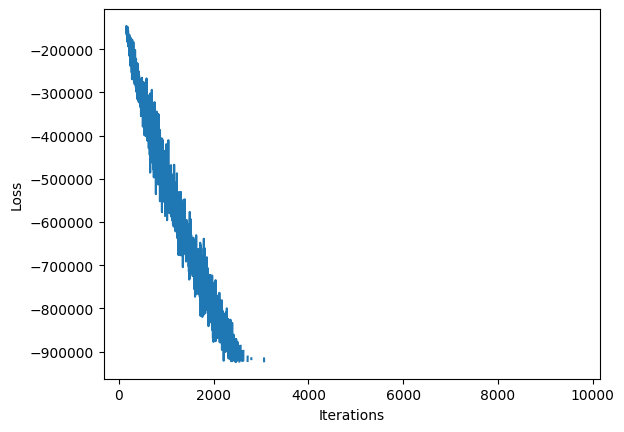

SVI Completed and saved.


In [ ]:
# ---------------------------
# Run SVI
# ---------------------------

print("Running Cox-Hawkes SVI...")

coxhawkes_cov.run_svi(num_steps=SVI_STEPS, lr=SVI_LR, plot_loss=True)
coxhawkes_cov.save_rslts(f"{OUTPUT_DIR}/coxhawkes_cov_svi.pkl")

print("SVI Completed and saved.")

In [ ]:
coxhawkes_cov.expected_AIC()

-946159.0

0.9825992584228516

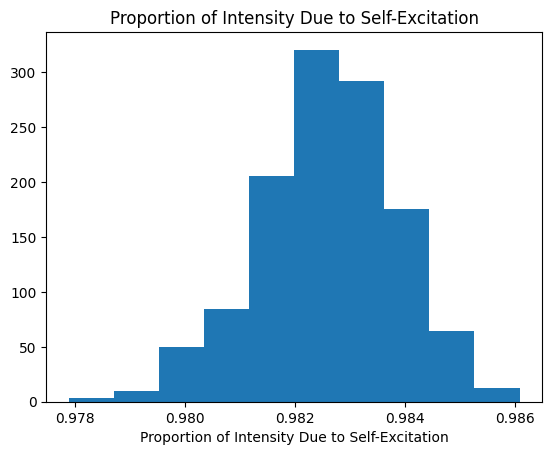

In [ ]:
coxhawkes_cov.plot_prop_excitation()

,Post Mean,Post Std,P(w>0),[0.025,0.975]
alpha,9.855646e-01,1.181116e-03,1.0,9.830803e-01,9.876745e-01
beta,2.689234e-20,9.522574e-21,1.0,1.283382e-20,4.874502e-20
sigmax_2,4.276932e-02,9.948945e-04,1.0,4.084478e-02,4.463616e-02


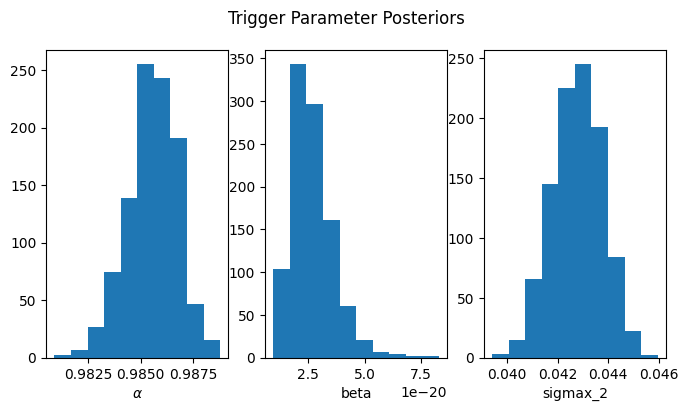

In [ ]:
coxhawkes_cov.plot_trigger_posterior(trace=False)

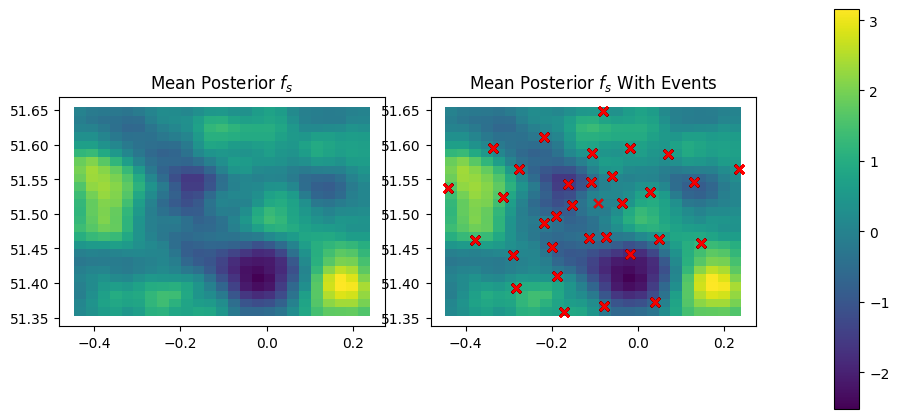

In [ ]:
coxhawkes_cov.plot_spatial()

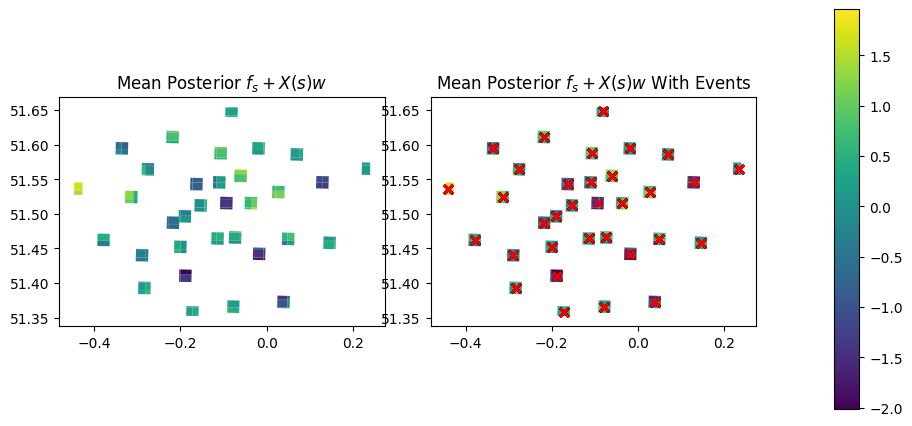

In [ ]:
coxhawkes_cov.plot_spatial(include_cov=True)

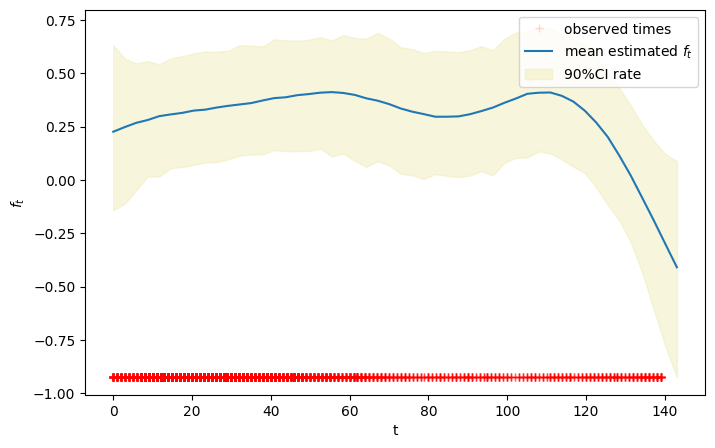

In [ ]:
coxhawkes_cov.plot_temporal()

,Post Mean,Post Std,P(w>0),[0.025,0.975]
popdensity,0.229344,0.086844,0.996,0.058837,0.401880
covid_deaths,-0.342860,0.070996,0.000,-0.477082,-0.209572
popn,0.501779,0.083468,1.000,0.345564,0.668351
houseprice,0.201601,0.099381,0.973,-0.000183,0.392257
a_0,2.885534,0.121238,1.000,2.645222,3.116837


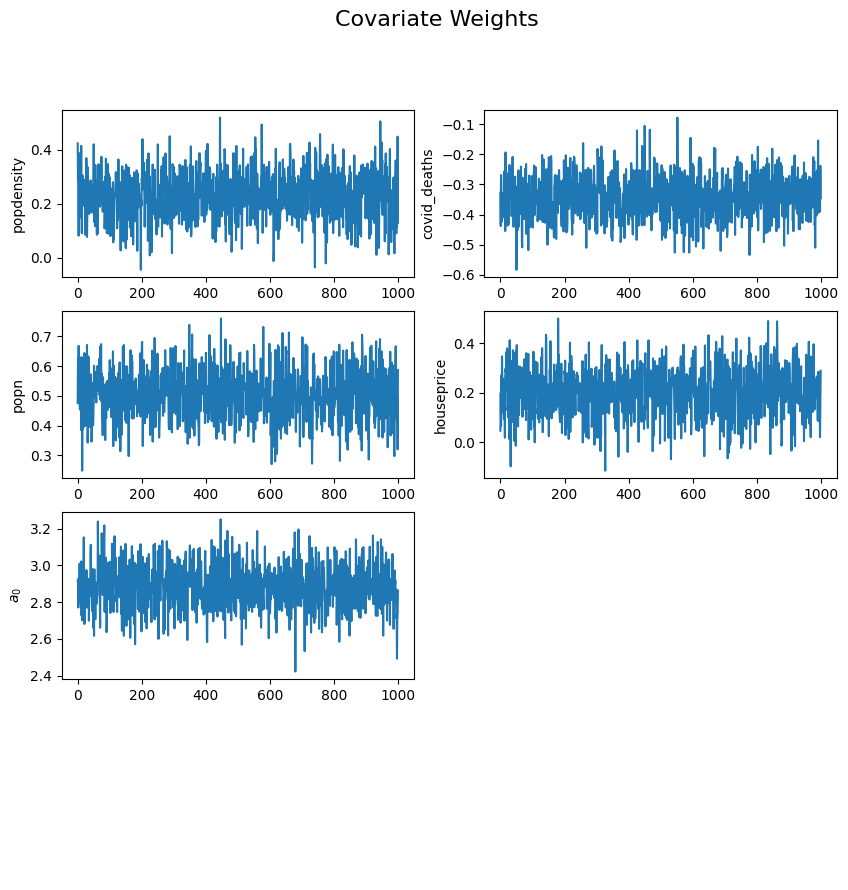

In [ ]:
coxhawkes_cov.cov_weight_post_summary(trace=True)

In [ ]:
 #---------------------------
# Run MCMC
# ---------------------------

print("Running coxhawkes_cov MCMC...")

coxhawkes_cov.run_mcmc(num_warmup=MCMC_WARMUP, num_samples=MCMC_SAMPLES, num_chains=MCMC_CHAINS)
coxhawkes_cov.save_rslts(f"{OUTPUT_DIR}/coxhawkes_cov_mcmc.pkl")

print("MCMC Completed and saved.")


Running coxhawkes_cov MCMC...


  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/jax/_src/interpreters/mlir.py:1132: UserWarning: A large amount of constants were captured during lowering (2.40GB total). If this is intentional, disable this warning by setting JAX_CAPTURED_CONSTANTS_WARN_BYTES=-1. To obtain a report of where these constants were encountered, set JAX_CAPTURED_CONSTANTS_REPORT_FRAMES=-1.
  warnings.warn(message)
sample: 100%|██████████| 500/500 [02:22<00:00,  3.50it/s, 1 steps of size 4.48e-06. acc. prob=0.32]  



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
           a_0      4.96      0.00      4.96      4.96      4.96     11.30      1.00
         alpha      0.92      0.00      0.92      0.92      0.92      4.63      1.41
          beta      0.00      0.00      0.00      0.00      0.00       nan       nan
      sigmax_2      0.04      0.00      0.04      0.04      0.04     10.69      1.00
          w[0]      0.34      0.00      0.34      0.34      0.34      2.73      2.53
          w[1]     -0.13      0.00     -0.13     -0.13     -0.13      4.84      1.13
          w[2]      0.32      0.00      0.32      0.32      0.32      5.25      1.28
          w[3]      0.19      0.00      0.19      0.19      0.19      2.98      1.76
  z_spatial[0]      0.35      0.00      0.35      0.35      0.35     11.71      1.02
  z_spatial[1]      0.65      0.00      0.65      0.65      0.65      6.12      1.29
  z_spatial[2]      0.46      0.00      0.46      0.46      0.46

In [ ]:
coxhawkes_cov.expected_AIC()

-923612.375

0.9736709594726562

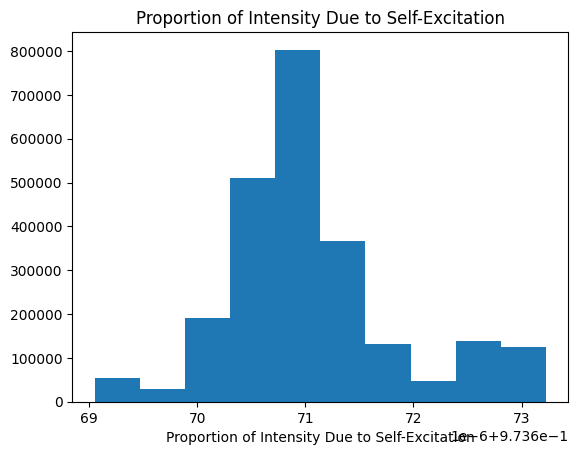

In [ ]:
coxhawkes_cov.plot_prop_excitation()

,Post Mean,Post Std,P(w>0),[0.025,0.975]
alpha,9.175012e-01,3.974991e-06,1.0,9.174916e-01,9.175099e-01
beta,7.763255e-20,0.000000e+00,1.0,7.762662e-20,7.764469e-20
sigmax_2,3.984854e-02,9.258255e-07,1.0,3.984646e-02,3.985015e-02


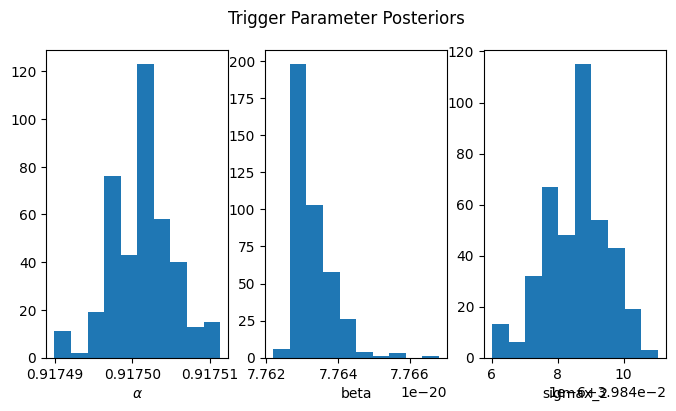

In [ ]:
coxhawkes_cov.plot_trigger_posterior(trace=False)

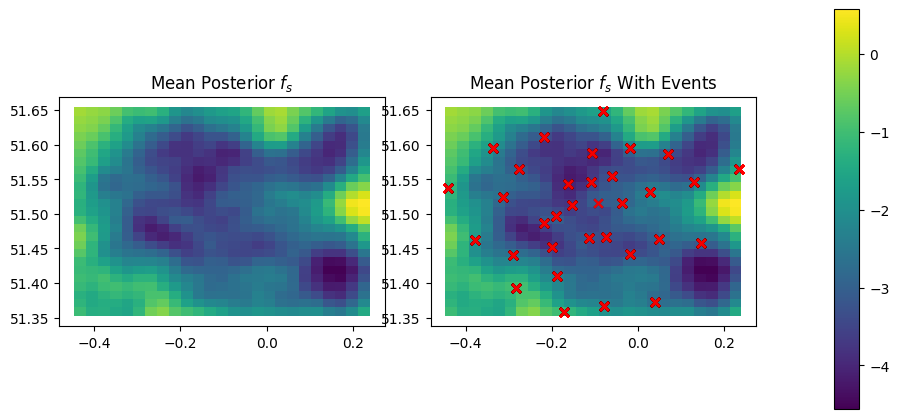

In [ ]:
coxhawkes_cov.plot_spatial()

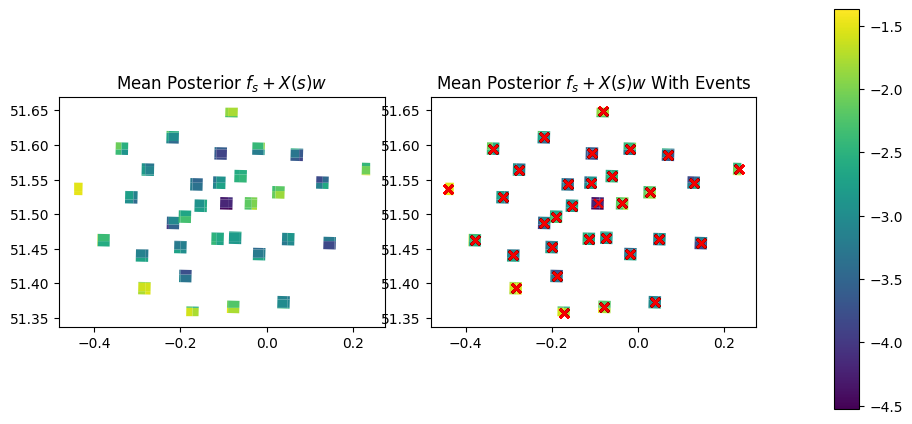

In [ ]:
coxhawkes_cov.plot_spatial(include_cov=True)

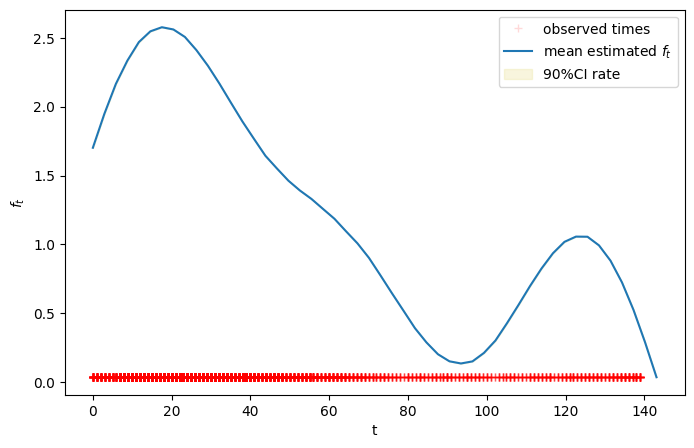

In [ ]:
coxhawkes_cov.plot_temporal()

,Post Mean,Post Std,P(w>0),[0.025,0.975]
popdensity,0.340939,0.000004,1.0,0.340931,0.340944
covid_deaths,-0.126626,0.000003,0.0,-0.126631,-0.126621
popn,0.323284,0.000003,1.0,0.323279,0.323288
houseprice,0.187947,0.000006,1.0,0.187940,0.187959
a_0,4.960586,0.000017,1.0,4.960579,4.960616


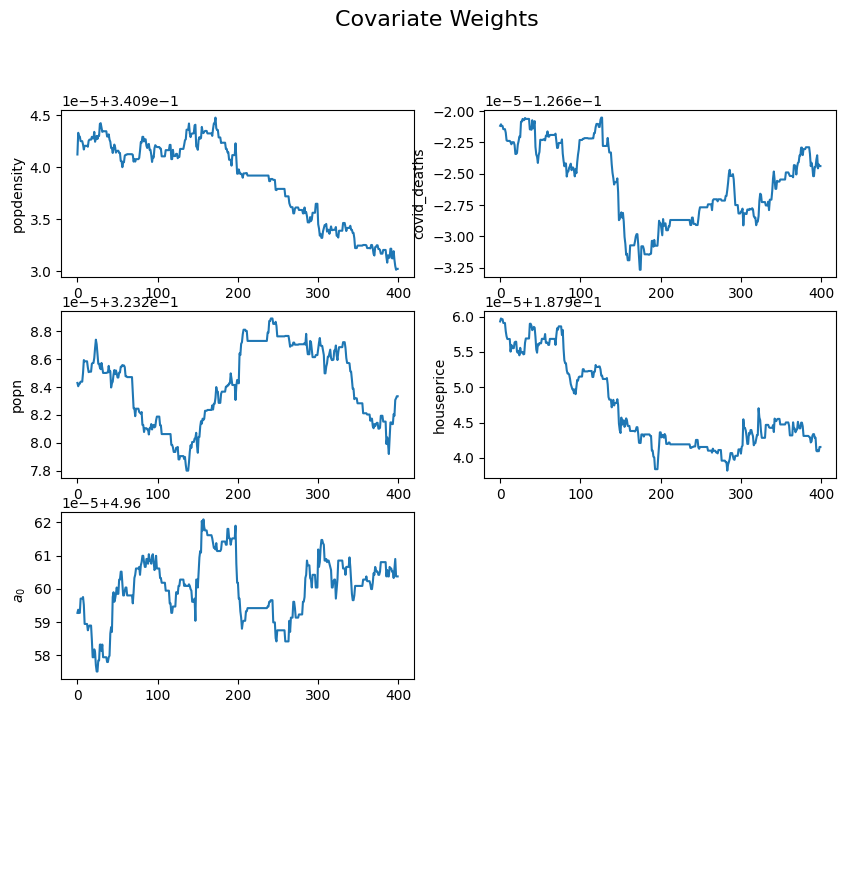

In [ ]:
coxhawkes_cov.cov_weight_post_summary(trace=True)

# Hawkes


In [ ]:
priors = {
    "a_0": dist.Normal(1, 10),
    "alpha": dist.Beta(20, 60),
    "beta": dist.HalfNormal(2.0),
    "sigmax_2": dist.HalfNormal(0.25)
}
hawkes = Hawkes_Model(events_df, grid_bounds, T_max, **priors)


In [ ]:
hawkes.run_mcmc(num_warmup=MCMC_WARMUP, num_samples=MCMC_SAMPLES, num_chains=MCMC_CHAINS)
hawkes.save_rslts(f"{OUTPUT_DIR}/hawkes_mcmc.pkl")

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/jax/_src/interpreters/mlir.py:1132: UserWarning: A large amount of constants were captured during lowering (2.40GB total). If this is intentional, disable this warning by setting JAX_CAPTURED_CONSTANTS_WARN_BYTES=-1. To obtain a report of where these constants were encountered, set JAX_CAPTURED_CONSTANTS_REPORT_FRAMES=-1.
  warnings.warn(message)
sample: 100%|██████████| 500/500 [01:37<00:00,  5.11it/s, 2 steps of size 1.28e-06. acc. prob=0.63]  



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
           a_0      1.93      0.00      1.93      1.93      1.93      9.04      1.00
         alpha      0.91      0.00      0.91      0.91      0.91      3.34      1.44
          beta      1.13      0.00      1.13      1.13      1.13      4.22      1.50
      sigmax_2      0.00      0.00      0.00      0.00      0.00       nan       nan
  z_spatial[0]      0.94      0.00      0.94      0.94      0.94      3.32      1.46
  z_spatial[1]      0.40      0.00      0.40      0.40      0.40      5.29      1.00
  z_spatial[2]      0.76      0.00      0.76      0.76      0.76      1.50      1.13
  z_spatial[3]      0.02      0.00      0.02      0.02      0.02      5.97      1.63
  z_spatial[4]     -0.63      0.00     -0.63     -0.63     -0.63      0.61      1.01
  z_spatial[5]      0.09      0.00      0.09      0.09      0.09     13.57      1.00
  z_spatial[6]      0.90      0.00      0.90      0.90      0.90

In [ ]:
hawkes.expected_AIC()

-870000.0625

/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


0.9973240494728088

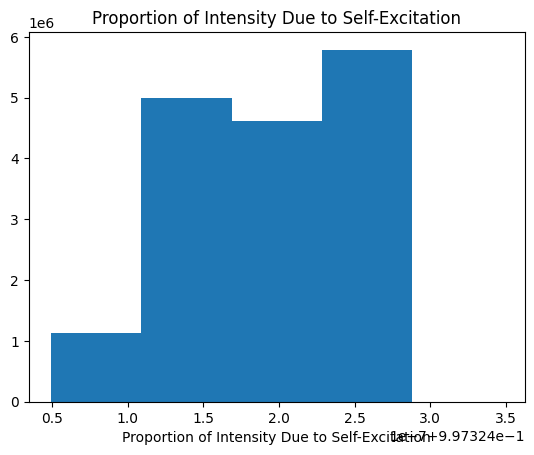

In [ ]:
hawkes.plot_prop_excitation()

,Post Mean,Post Std,P(w>0),[0.025,0.975]
alpha,9.078221e-01,0.000001,1.0,9.078191e-01,9.078236e-01
beta,1.125950e+00,0.000010,1.0,1.125932e+00,1.125968e+00
sigmax_2,6.690545e-20,0.000000,1.0,6.690097e-20,6.691578e-20


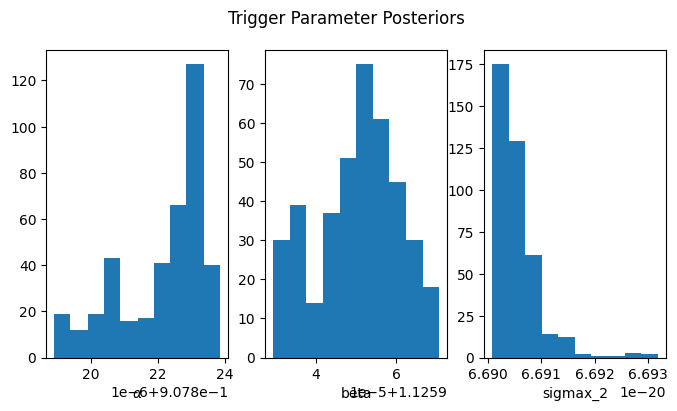

In [ ]:
hawkes.plot_trigger_posterior(trace=False)

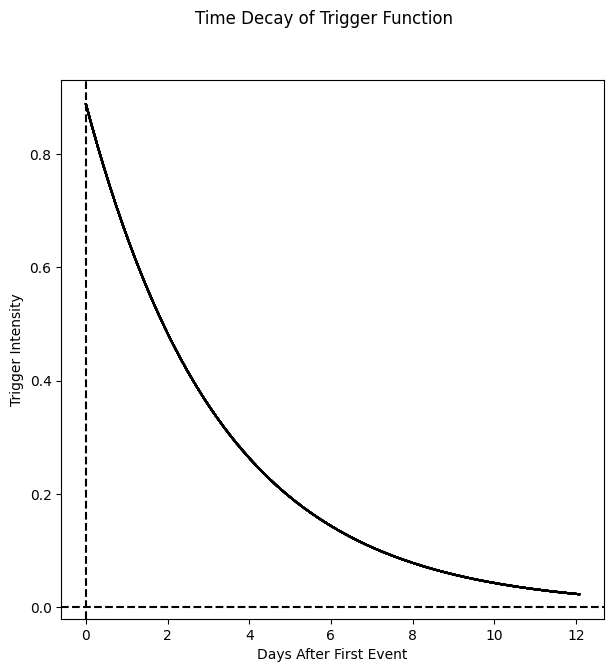

In [ ]:
hawkes.plot_trigger_time_decay()

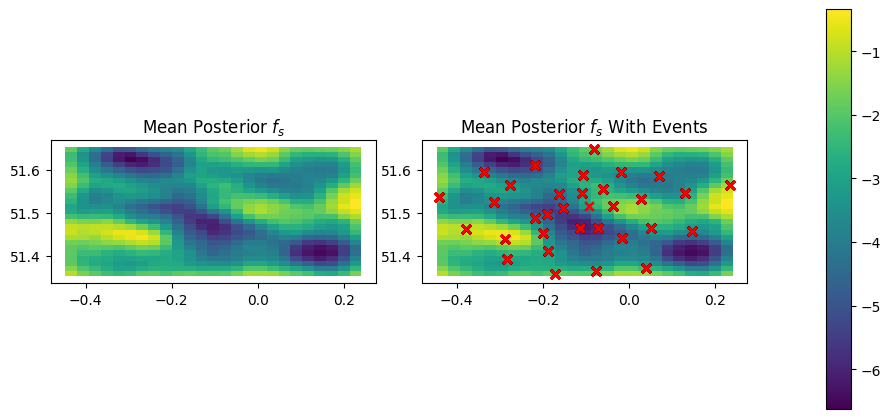

In [ ]:
hawkes.plot_spatial()

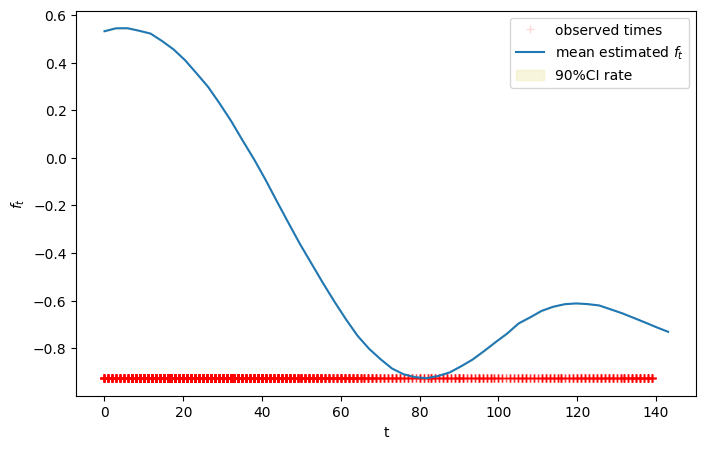

In [ ]:
hawkes.plot_temporal()

  0%|          | 0/15000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/jax/_src/interpreters/mlir.py:1132: UserWarning: A large amount of constants were captured during lowering (2.40GB total). If this is intentional, disable this warning by setting JAX_CAPTURED_CONSTANTS_WARN_BYTES=-1. To obtain a report of where these constants were encountered, set JAX_CAPTURED_CONSTANTS_REPORT_FRAMES=-1.
  warnings.warn(message)
100%|██████████| 15000/15000 [04:16<00:00, 58.56it/s, init loss: -76479.2344, avg. loss [14251-15000]: nan]         


Sampling Posterior...

SVI elapsed time: 276.38705611228943


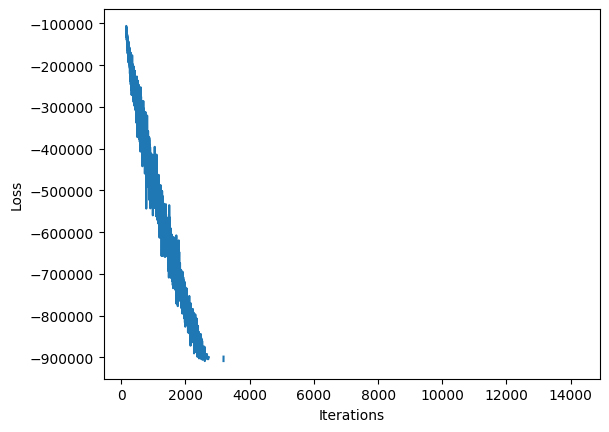

In [ ]:
hawkes.run_svi(num_steps=SVI_STEPS, lr=SVI_LR, plot_loss=True)
hawkes.save_rslts(f"{OUTPUT_DIR}/hawkes_svi.pkl")

In [ ]:
hawkes.expected_AIC()

-925119.4375

0.9825335144996643

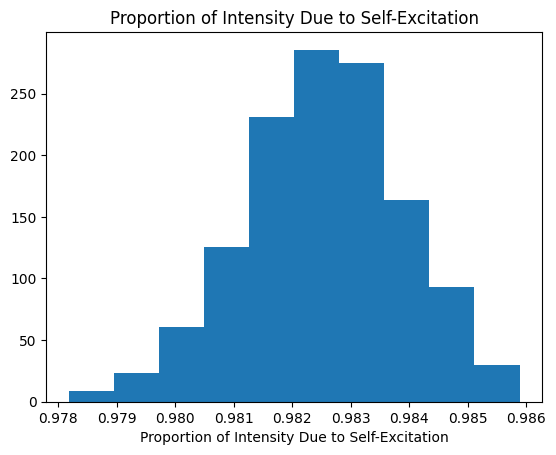

In [ ]:
hawkes.plot_prop_excitation()

,Post Mean,Post Std,P(w>0),[0.025,0.975]
alpha,9.847167e-01,1.172001e-03,1.0,9.823172e-01,9.869884e-01
beta,7.501268e-20,2.489632e-20,1.0,3.841932e-20,1.344548e-19
sigmax_2,4.271974e-02,9.369756e-04,1.0,4.096561e-02,4.458066e-02


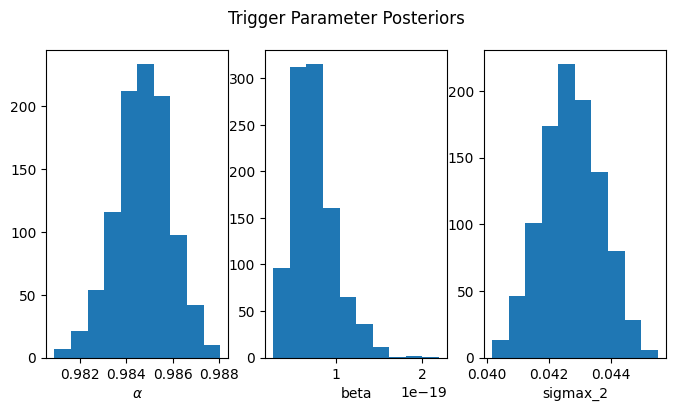

In [ ]:
hawkes.plot_trigger_posterior(trace=False)

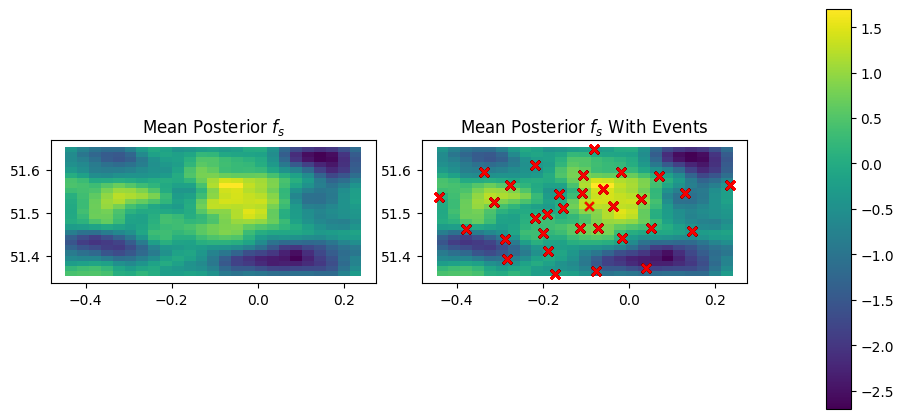

In [ ]:
hawkes.plot_spatial()

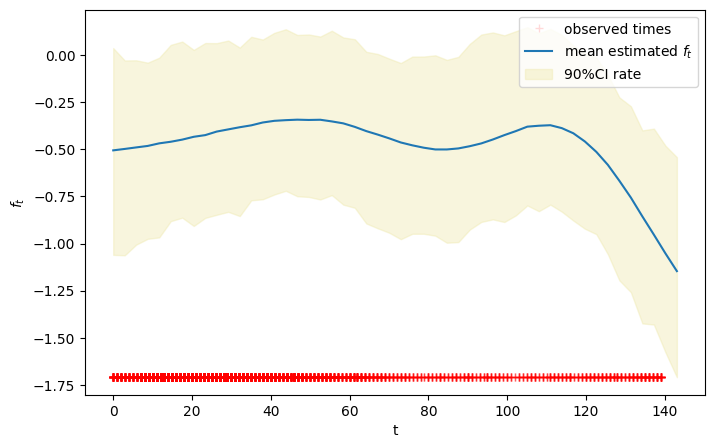

In [ ]:
hawkes.plot_temporal()

In [ ]:
print("\n=== Loading Results and Calculating Expected AICs ===")

# Hawkes (MCMC)
hawkes.load_rslts(f"{OUTPUT_DIR}/hawkes_mcmc.pkl")
hawkes_MCMC_aic = hawkes.expected_AIC()
print("Expected AIC (Hawkes MCMC):", hawkes_MCMC_aic)

# Hawkes (SVI)
hawkes.load_rslts(f"{OUTPUT_DIR}/hawkes_svi.pkl")
hawkes_SVI_aic = hawkes.expected_AIC()
print("Expected AIC (Hawkes SVI:", hawkes_SVI_aic)

# LGCP_cov (SVI)
lgcp_cov.load_rslts(f"{OUTPUT_DIR}/lgcp_cov_svi.pkl")
lgcp_cov_svi_aic = lgcp_cov.expected_AIC()
print("Expected AIC (LGCP_cov SVI):", lgcp_cov_svi_aic)

# LGCP_cov (MCMC)
lgcp_cov.load_rslts(f"{OUTPUT_DIR}/lgcp_cov_mcmc.pkl")
lgcp_cov_mcmc_aic = lgcp_cov.expected_AIC()
print("Expected AIC (LGCP_cov MCMC):", lgcp_cov_mcmc_aic)


# Cox-Hawkes_cov (SVI)
coxhawkes_cov.load_rslts(f"{OUTPUT_DIR}/coxhawkes_cov_svi.pkl")
coxhawkes_cov_svi_aic = coxhawkes_cov.expected_AIC()
print("Expected AIC (Cox-Hawkes_cov SVI):", coxhawkes_cov_svi_aic)

# Cox-Hawkes_cov (MCMC)
coxhawkes_cov.load_rslts(f"{OUTPUT_DIR}/coxhawkes_cov_mcmc.pkl")
coxhawkes_cov_mcmc_aic = coxhawkes_cov.expected_AIC()
print("Expected AIC (Cox-Hawkes_cov MCMC):", coxhawkes_cov_mcmc_aic)

# -------------------------------
# Comparison + Best Model
# -------------------------------

print("\n=== Model Comparison (Expected AIC) ===")
model_aics = {
    "Hawkes (MCMC)": hawkes_MCMC_aic,
     "Hawkes (SVI)": hawkes_SVI_aic,
    "LGCP_cov (SVI)": lgcp_cov_svi_aic,
    "LGCP_cov (MCMC)": lgcp_cov_mcmc_aic,
    "Cox-Hawkes_cov (SVI)": coxhawkes_cov_svi_aic,
    "Cox-Hawkes_cov (MCMC)": coxhawkes_cov_mcmc_aic
}

# Sort models by AIC
sorted_aic = sorted(model_aics.items(), key=lambda x: x[1])

# Print nicely
for model_name, aic in sorted_aic:
    print(f"{model_name}: Expected AIC = {aic:.2f}")

# Best model
best_model = sorted_aic[0]
print(f"\nBest model based on Expected AIC: {best_model[0]} (AIC = {best_model[1]:.2f})")



=== Loading Results and Calculating Expected AICs ===
Expected AIC (Hawkes MCMC): -870000.0625
Expected AIC (Hawkes SVI: -925119.4375
Expected AIC (LGCP_cov SVI): -147679.046875
Expected AIC (LGCP_cov MCMC): -147684.125
Expected AIC (Cox-Hawkes_cov SVI): -946159.0
Expected AIC (Cox-Hawkes_cov MCMC): -923612.375

=== Model Comparison (Expected AIC) ===
Cox-Hawkes_cov (SVI): Expected AIC = -946159.00
Hawkes (SVI): Expected AIC = -925119.44
Cox-Hawkes_cov (MCMC): Expected AIC = -923612.38
Hawkes (MCMC): Expected AIC = -870000.06
LGCP_cov (MCMC): Expected AIC = -147684.12
LGCP_cov (SVI): Expected AIC = -147679.05

Best model based on Expected AIC: Cox-Hawkes_cov (SVI) (AIC = -946159.00)
